In [115]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from collections import Counter
# import spacy
# nlp = spacy.load('en_core_web_sm')

# from spacy.lang.en import English
# tokenizer = English().Defaults.create_tokenizer(nlp)


# def my_spacy_tokenizer(doc):
#     # TODO: need to add a phase to break -- offsets and strip white space.
#     tokens = tokenizer(doc)
#     return([token.text for token in tokens])




In [50]:

turk_df = pd.read_csv('batches/Batch_3613145_batch_results.csv') # empathetic-s2s


In [51]:
list(turk_df.columns)

['HITId',
 'HITTypeId',
 'Title',
 'Description',
 'Keywords',
 'Reward',
 'CreationTime',
 'MaxAssignments',
 'RequesterAnnotation',
 'AssignmentDurationInSeconds',
 'AutoApprovalDelayInSeconds',
 'Expiration',
 'NumberOfSimilarHITs',
 'LifetimeInSeconds',
 'AssignmentId',
 'WorkerId',
 'AssignmentStatus',
 'AcceptTime',
 'SubmitTime',
 'AutoApprovalTime',
 'ApprovalTime',
 'RejectionTime',
 'RequesterFeedback',
 'WorkTimeInSeconds',
 'LifetimeApprovalRate',
 'Last30DaysApprovalRate',
 'Last7DaysApprovalRate',
 'Input.msg1_0',
 'Input.msg2_0',
 'Input.resp_1_0',
 'Input.model_1_0',
 'Input.resp_2_0',
 'Input.model_2_0',
 'Input.resp_3_0',
 'Input.model_3_0',
 'Input.resp_4_0',
 'Input.model_4_0',
 'Input.msg1_1',
 'Input.msg2_1',
 'Input.resp_1_1',
 'Input.model_1_1',
 'Input.resp_2_1',
 'Input.model_2_1',
 'Input.resp_3_1',
 'Input.model_3_1',
 'Input.resp_4_1',
 'Input.model_4_1',
 'Input.msg1_2',
 'Input.msg2_2',
 'Input.resp_1_2',
 'Input.model_1_2',
 'Input.resp_2_2',
 'Input.mod

In [63]:
turk_df['Answer.Justified Answer'].values

array(['{}',
       '"That\'s cool!" is the only coherent answer that directly responds to person 2.',
       'most interesting had an opportunity to continue the conversation',
       'The most relevant is the only choice that a nice response. The most interesting one is not relevant but it is still about sports',
       '{}', '{}',
       'Most relevant had to do with the conversation and most interesting was more irrelevant but seemed more interesting.',
       'he said he played tennis it has no link with the conversation but he brings something new',
       'I chose whichever answer was relevant and not a total gibberish.',
       "Most Relevant:  Straight to the point acknowledging Person 2's response.\rMost Interesting:  Moves the conversation along to a weirdly placed but unique fact about Person 1.",
       'The statement about tennis tells more of a story.',
       'I looked for the comment that related most closely to the topic for most relevant. I chose the comment that mad

In [62]:
turk_df['Answer.optionalfeedback'].values

array(['{}', '{}', '{}', '{}', 'none', '{}', '{}',
       "there's always 1 answer that looks like a mismatch between multiple sentece so i kept reporting ( not grammatical ) on them even if the sentences individually were correct",
       '{}', 'Thank you for the opportunity to work on this HIT!', '{}',
       '{}',
       'The assignment was not straightforward and leaves room for interpretation.  For example, one speaker said that a sister was favored and she was ignored.  It would be interesting if someone said, that\'s so sweet, it could imply sarcasm or some other features that involve the way we talk to one another.  Saying "i hope she gets better soon" opens up conversations about a possible serious illness which is also interesting.  Like wise saying "that sounds like a lot of fun" can be sarcasm if it\'s in response to finding a lost item, in that case it would be interesting but relevant.',
       '{}', '{}', '{}',
       "This is a strange task, in that for several conversa

# Check results on the warmup question

### Which option was selected as most interesting response:

In [60]:
turk_df['Answer.int_warmup'].values

array([3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3,
       1, 3, 1, 1, 3, 3, 1, 3])

### Which option was selected as most relevant response:

In [61]:
turk_df['Answer.rel_warmup'].values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

### Number of times each option was flagged as not grammatical

In [72]:
print('below are counts out of %s:' % turk_df.shape[0])
print(np.sum(~np.isnan(turk_df['Answer.gram_warmup_2'].values)))
print(np.sum(~np.isnan(turk_df['Answer.gram_warmup_3'].values)))
print(np.sum(~np.isnan(turk_df['Answer.gram_warmup_4'].values)))

below are counts out of 30:
26
3
24


In [83]:

model_order = ['s2s', 'idf', 'idfswapping', 'face']
choice_df = []
grammar_df = []
for i in turk_df.index:
    row = turk_df.loc[i]
    hit_num = i
    worker_id = row['WorkerId']
    for ex in range(10): 
        
        option_to_model = {}
        model_to_resp = {}
        model_to_gram = {}
        for option in range(1, 5):
            dataset, model = row['Input.model_%s_%s' % (option, ex)].split(' ')
            option_to_model[option] = model
            model_to_resp[model] = row['Input.resp_%s_%s' % (option, ex)]
            
            model_to_gram[model] = np.isnan(row['Answer.gram_%s_%s' % (ex, option)])
            
        most_interesting = option_to_model[row['Answer.int_%s' % (ex,)]]
        most_relevant = option_to_model[row['Answer.rel_%s' % (ex,)]]
        message1 = row['Input.msg1_%s' % (ex,)]
        message2 = row['Input.msg2_%s' % (ex,)]
        
        
        choice_df.append([hit_num, worker_id, dataset, most_interesting, most_relevant, \
                          message1, message2] + [model_to_resp[m] for m in model_order] \
                        + [model_to_gram[m] for m in model_order])

choice_df = pd.DataFrame(choice_df, columns = ['hit_num', 'worker_id', 'dataset', 'most_int', 'most_rel', \
                                              'message1', 'message2']\
                                             + model_order \
                                                + ['gram_%s' % m for m in model_order])

choice_df['context'] = choice_df['message1'] + choice_df['message2']
#         response = row['Input.resp_%s' % ex]
#         grammar = row['Answer.gram_pairanswer_%s'% ex]
#         interesting = row['Answer.int_pairanswer_%s'% ex]
#         relevant = row['Answer.resp_pairanswer_%s'% ex]
        
#         label_df.append([dataset, model, exname, response, grammar, interesting, relevant])
        
# label_df = pd.DataFrame(label_df, columns = ['dataset', 'model', 'exname', 'response', 
#                                        'grammar', 'interesting', 'relevant'])

In [93]:
print(choice_df.shape)
choice_df[:3]

(300, 16)


,hit_num,worker_id,dataset,most_int,most_rel,message1,message2,s2s,idf,idfswapping,face,gram_s2s,gram_idf,gram_idfswapping,gram_face,context
0,0,A1PUHCEBSOWETV,Empathetic,idfswapping,face,--,i wish i never did it now. i thought it wasn't...,oh no ! what happened ?,what happened ?,why did you do ?,why do you feel about it ? what was your favor...,True,True,True,True,--i wish i never did it now. i thought it wasn...
1,0,A1PUHCEBSOWETV,Empathetic,idfswapping,s2s,--,my brother and i recently had to sell a house ...,oh no ! i 'm sorry to hear that . what happened ?,oh no :( what happened ?,what kind of car is it ?,how long has he been there ? how long has he b...,True,True,True,True,--my brother and i recently had to sell a hous...
2,0,A1PUHCEBSOWETV,Empathetic,idf,idfswapping,--,"today i think today is a day to learn, to hug,...",that 's awesome ! how long have you been toget...,that sounds like fun ! what are you planning o...,"wow , that sounds exciting ! how old are you g...",that 's great ! how long have you been togethe...,True,True,True,True,"--today i think today is a day to learn, to hu..."


### Number of wins on Interestingness for each method

In [64]:
choice_df.groupby('most_int')['hit_num'].agg('count')

most_int
face           47
idf            89
idfswapping    98
s2s            66
Name: hit_num, dtype: int64

### Number of wins on Relevance for each method

In [65]:
choice_df.groupby('most_rel')['hit_num'].agg('count')

most_rel
face            24
idf             72
idfswapping     85
s2s            119
Name: hit_num, dtype: int64

### Number of responses/method flagged as not-grammatical

In [92]:
print('Num not-grammatical out of %s ' % choice_df.shape[0])
choice_df.shape[0] - choice_df[['gram_%s' % m for m in model_order]].sum()

Num not-grammatical out of 300 


gram_s2s             24
gram_idf             38
gram_idfswapping     34
gram_face           183
dtype: int64

# Let's look at agreement between workers

In [118]:
num_selected = {'int':[], 'rel':[]}
selected_when_less_2 = {'int':[], 'rel':[]}

for context, df in choice_df.groupby('context'):
    
    for s in ['int', 'rel']:
        num_selected[s].append(df['most_%s' % s].unique().shape[0])
        if df['most_%s' % s].unique().shape[0] < 3:
            selected_when_less_2[s].append(df['most_%s' % s].mode().values[0])

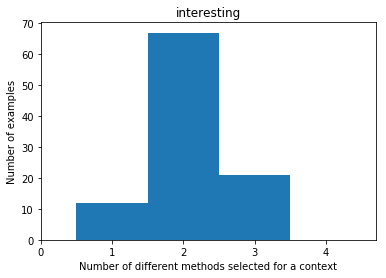

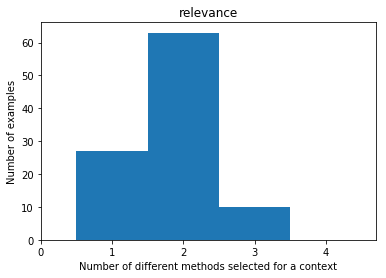

In [119]:
plt.hist(num_selected['int'], bins=np.arange(5)+.5)
plt.xticks(np.arange(5))
plt.ylabel('Number of examples')
plt.xlabel('Number of different methods selected for a context')
plt.title('interesting')
plt.show()


plt.hist(num_selected['rel'], bins=np.arange(5)+.5)
plt.xticks(np.arange(5))
plt.ylabel('Number of examples')
plt.xlabel('Number of different methods selected for a context')
plt.title('relevance')
plt.show()


### Which method wins when workers agree? 

In [131]:
counts_workers_agree = {'int':[], 'rel':[]}

for s in ['int', 'rel']:
    print(s)
    counts_workers_agree[s] = Counter(selected_when_less_2[s])
    print('\n'.join(['%s: %s' % (m, counts_workers_agree[s][m]) for m in model_order])+'\n\n')

int
s2s: 16
idf: 25
idfswapping: 28
face: 10


rel
s2s: 39
idf: 22
idfswapping: 25
face: 4




# Worker stats

In [123]:
choice_df.groupby('worker_id').agg(np.size)

,hit_num,dataset,most_int,most_rel,message1,message2,s2s,idf,idfswapping,face,gram_s2s,gram_idf,gram_idfswapping,gram_face,context
worker_id,,,,,,,,,,,,,,,
A110KENBXU7SUJ,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
A11Q8U6QTT8KGF,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
A1ATL3G98SFW4V,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
A1ET2J1PIP0RGO,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20
A1JVO7FLPATHUB,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
A1PUHCEBSOWETV,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20
A1QKIA8XRNEXIG,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
A1R8RBXRU2T6HZ,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
A1SP3GBRZKMWZJ,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
